Práctica 2: Regresión logística
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---

In [2]:
%matplotlib notebook
import csv
import numpy as np
import scipy.optimize as opt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import PolynomialFeatures

Carga y muestra de datos.

In [3]:
def carga_csv(filename):
    valores = read_csv(filename,header= None).values
    return valores.astype(float)

In [4]:
val = carga_csv("ex2data1.csv")
Y = val[:,2]
X = []
for i in range (len(Y)):
    X.append([1.,val[i,0],val[i,1]])
th =np.zeros((3,1))

Para que resulten más fáciles de visualizar, distinguimos los datos según su resultado. La cruces representan los alumnos admitidos mientras que los puntos son los no admitidos.

<IPython.core.display.Javascript object>


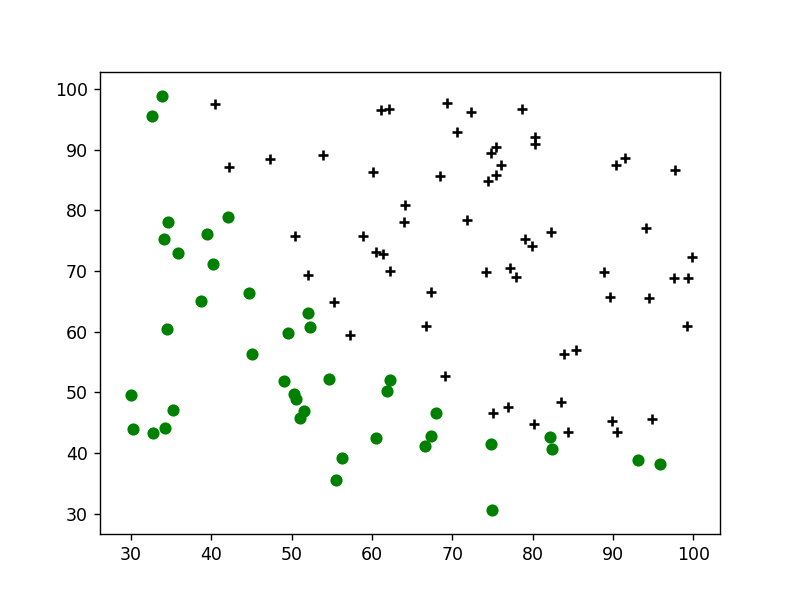

In [5]:
pos= np.where(Y)
npos = np.where(Y <1)
plt.scatter(val[pos,0], val[pos,1], marker= '+', c='k')
plt.scatter(val[npos,0], val[npos,1], c='g')


Función sigmoide
---

In [7]:
def sigmoide(z):
    s = np.dot(z,-1)
    e = np.exp(s)
    d = 1 + e
    return 1/d

Funciones de coste y gradiente
---
Junto con su resultado, con theta inicializada a 0.

In [8]:
def coste(th,x,y):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)
    return c/len(y)

coste(th,X,Y)

array([0.69314718])

In [9]:
def gradiente(th,x,y):
    g = sigmoide(np.dot(x,th))
    tr = np.transpose(x)
    g2 = np.transpose(np.transpose(g)-y)
    gr = np.dot(tr,g2)
    return gr/len(y)

gradiente(th,X,Y)

array([[ -0.1       ],
       [-12.00921659],
       [-11.26284221]])

Optimización de los parámetros
---
Utilizando fmin_tnc, junto a las funciones ya definidas de coste y gradiente, podemos obtener una theta óptima para nuestro problema.

In [15]:
result = opt.fmin_tnc(func=coste, x0=th, fprime=gradiente, args=(X, Y))
th_opt = result[0]

Función dada para pintar la frontera de decisión.

In [16]:
def pinta_frontera_recta(X, Y, theta):
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
    np.linspace(x2_min, x2_max))

    h = sigmoide(np.c_[np.ones((xx1.ravel().shape[0], 1)),
    xx1.ravel(),
    xx2.ravel()].dot(theta))
    h = h.reshape(xx1.shape)

    # el cuarto parámetro es el valor de z cuya frontera se
    # quiere pintar
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

De nuevo, distinguimos los alumnos admitidos y no admitidos y podemos ver que la recta o frontera de decisión los separa de forma que se mantengan correctas la mayoría de las predicciones.

<IPython.core.display.Javascript object>


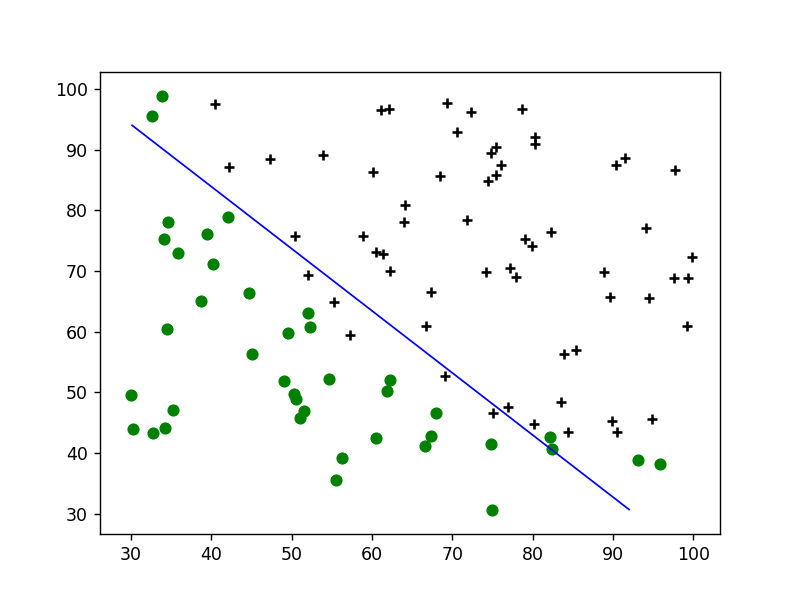

In [17]:
pos= np.where(Y)
npos = np.where(Y <1)
plt.figure()
plt.scatter(val[pos,0], val[pos,1], marker= '+', c='k')
plt.scatter(val[npos,0], val[npos,1], c='g')
pinta_frontera_recta(val,Y,th_opt)

Función que calcula el porcentaje de predicciones correctas, en función de la theta calculada anteriormente. Distingue los casos de admitidos o no admitidos. 
Por los resultados, podemos ver que nuestra frontera distingue un 89% de casos correctos.

In [19]:
def porcent_admit(th, x, y):
    sig = sigmoide(np.dot(th,np.transpose(x)))
    y_predA = np.where(sig >= 0.5)
    y_predNA = np.where(sig < 0.5)
    contA = 0
    contNA = 0
    aciertos = 0
    for i in range(len(y)):
        if contA < len(y_predA[0]):
            if i==y_predA[0][contA]:
                if y[i]==1:
                    aciertos +=1
                contA += 1
        if contNA < len(y_predNA[0]):
            if i ==y_predNA[0][contNA]:
                if y[i]==0:
                    aciertos += 1
                contNA +=1
    p = aciertos/len(y)*100
    return aciertos

porcent_admit(th_opt, X, Y)

89

Regresión logística regularizada
---
Carga y muestra de datos.
De nuevo, distinguimos los datos en función de su resultado (y). Las cruces marcan los casos en los que y = 1.

<IPython.core.display.Javascript object>


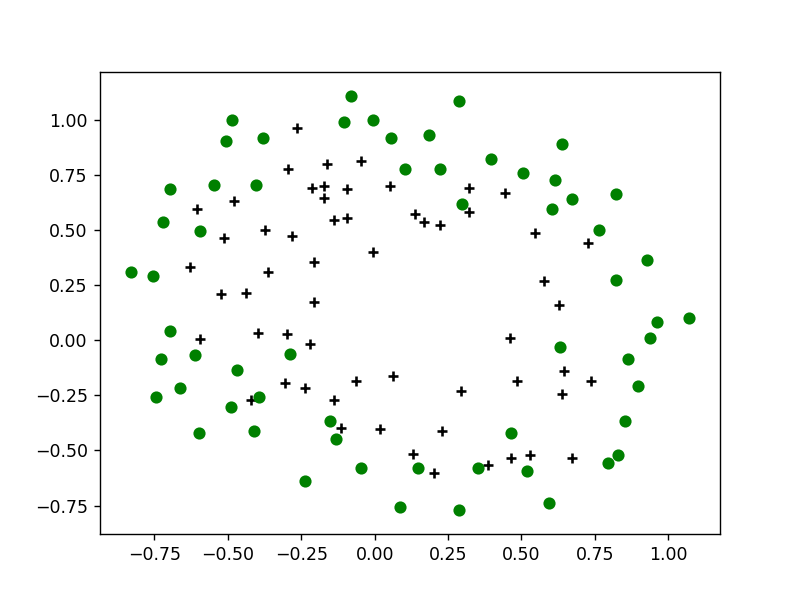

In [20]:
val2 = carga_csv("ex2data2.csv")
Y2 = val2[:,2]
X2 = val2[:,:2]
th2 =np.zeros((28,1))

pos2= np.where(Y2)
npos2 = np.where(Y2 <1)
plt.figure()
plt.scatter(val2[pos2,0], val2[pos2,1], marker= '+', c='k')
plt.scatter(val2[npos2,0], val2[npos2,1], c='g')

Mapeo de atributos.
De esta forma podemos conseguir más casos para comparar, valiéndonos de combinaciones entre los que ya tenemos.

In [21]:
poly =PolynomialFeatures(6)
X2 = poly.fit_transform(X2)

Funciones de coste y gradiente regularizadas.

In [22]:
def coste_reg(th, x, y, lamda=1):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)/len(y)
    s = np.sum(th2**2)/(2*len(Y))
    return c + lamda*s

In [23]:
def grad_reg(th,x,y,lamda=1):
    return np.dot(np.transpose(x),sigmoide(np.dot(x,th))-y)/len(y) + (lamda/len(y))*th

A partir de las nuevas funciones con el término de regularización añadido, calculamos la nueva theta óptima para nuestro problema.

In [24]:
result2 = opt.fmin_tnc(func=coste_reg, x0=th2, fprime=grad_reg, args=(X2, Y2,1))
th_opt2 = result2[0]

Función dada para dibujar la frontera de decisión.

In [25]:
def plot_decisionboundary(X, Y, theta, poly):
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
    np.linspace(x2_min, x2_max))
    h = sigmoide(poly.fit_transform(np.c_[xx1.ravel(),
    xx2.ravel()]).dot(theta))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g')

<IPython.core.display.Javascript object>


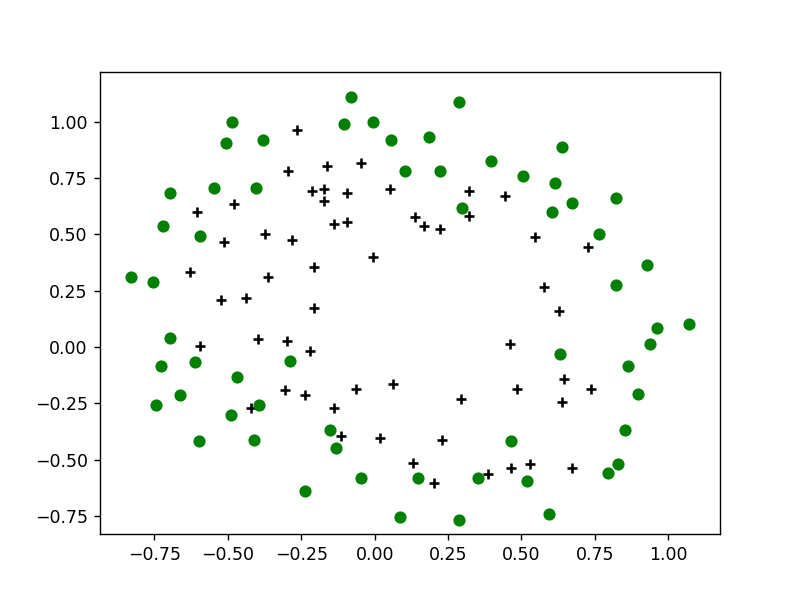

C:\Users\Lidia\AppData\Roaming\Python\Python36\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [53]:
pos2= np.where(Y2)
npos2 = np.where(Y2 <1)
plt.figure()
plt.scatter(val2[pos2,0], val2[pos2,1], marker= '+', c='k')
plt.scatter(val2[npos2,0], val2[npos2,1], c='g')
plot_decisionboundary(X2,Y2,th_opt2,poly)